In [1]:
import os
import random
import pickle
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing as mp
import matplotlib.pyplot as plt

from maze.maze import Maze, MazeSolution
from maze.dfs_gen import maze_dfs_gen, maze_chaos_dfs_gen
from maze.bfs_solve import maze_bfs_solve
from maze.dfs_solve import maze_dfs_solve, maze_dfs_solve_manhattan, maze_dfs_solve_euclidean
from maze.rnd_solve import maze_rnd_solve
from maze.astar_solve import maze_astar_solve_manhattan, maze_astar_solve_euclidean
from maze.bfirst_solve import maze_bfirst_solve_manhattan, maze_bfirst_solve_euclidean

In [2]:
# Use a fixed seed for reproducibility
seed = "a very happy seed :)"
rnd = random.Random(seed)

# Create the maze dataset
maze_count = 1000
sizes = [51, 101, 151, 201]
p_values = [0.0, 0.05, 0.1, 0.15, 0.2]

params = list(itertools.product(sizes, p_values))

mazes = {}

def maze_gen(size, p, seed):
    return maze_chaos_dfs_gen(size, size, seed=seed, p=p)

# Avoid re-generating the mazes as it can take a while
if os.path.exists("mazes.pickle"):
    with open("mazes.pickle", "rb") as f:
        mazes = pickle.load(f)
else:
    for param in params:
        print("Computing mazes for param", param)
        size, p = param
        seeds = [rnd.randint(0, 2**32) for _ in range(maze_count)]
        with mp.Pool() as pool:
            mazes[param] = pool.starmap(maze_gen, [(size, p, seed) for seed in seeds])

# Pickle it
with open("mazes.pickle", "wb") as f:
    pickle.dump(mazes, f)

In [3]:
results = {}
seed = "a somewhat happy seed :-)"
rnd = random.Random(seed)

def compute_solutions(maze, seed):
    bfs = maze_bfs_solve(maze)
    dfs = maze_dfs_solve(maze)
    rnd = maze_rnd_solve(maze, seed)
    astar_man = maze_astar_solve_manhattan(maze)
    astar_euc = maze_astar_solve_euclidean(maze)
    bfirst_man = maze_bfirst_solve_manhattan(maze)
    bfirst_euc = maze_bfirst_solve_euclidean(maze)

    return {
        'bfs': (len(bfs.steps), len(bfs.path)),
        'dfs': (len(dfs.steps), len(dfs.path)),
        'rnd': (len(rnd.steps), len(rnd.path)),
        'astar_man': (len(astar_man.steps), len(astar_man.path)),
        'astar_euc': (len(astar_euc.steps), len(astar_euc.path)),
        'bfirst_man': (len(bfirst_man.steps), len(bfirst_man.path)),
        'bfirst_euc': (len(bfirst_euc.steps), len(bfirst_euc.path)),
    }

# Avoid re-computing the results as it can take a while
if os.path.exists("results.pickle"):
    with open("results.pickle", "rb") as f:
        results = pickle.load(f)
else:
    for params, maze_list in mazes.items():
        size, p = params

        results[params] = {}
        seeds = [rnd.randint(0, 2**32) for _ in range(maze_count)]

        with mp.Pool() as pool:
            print("Computing results for param", params)
            raw_results = pool.starmap(compute_solutions, [(maze, seed) for maze, seed in zip(maze_list, seeds)])
            # Merge the results
            results[params]['bfs'] = [r['bfs'] for r in raw_results]
            results[params]['dfs'] = [r['dfs'] for r in raw_results]
            results[params]['rnd'] = [r['rnd'] for r in raw_results]
            results[params]['astar_man'] = [r['astar_man'] for r in raw_results]
            results[params]['astar_euc'] = [r['astar_euc'] for r in raw_results]
            results[params]['bfirst_man'] = [r['bfirst_man'] for r in raw_results]
            results[params]['bfirst_euc'] = [r['bfirst_euc'] for r in raw_results]
    
    with open("results.pickle", "wb") as f:
        pickle.dump(results, f)

In [4]:
pretty_names = {
    'bfs': 'BFS',
    'dfs': 'DFS',
    'rnd': 'Random',
    'astar_man': 'A* Manhattan',
    'astar_euc': 'A* Euclidean',
    'bfirst_man': 'Best First Manhattan',
    'bfirst_euc': 'Best First Euclidean',
}

blind_names = ('bfs', 'dfs', 'rnd')

<Axes: title={'center': 'Comparação de iterações e caminho de busca cega (101x101, p=0.1)'}, xlabel='Algoritmo', ylabel='Valor'>

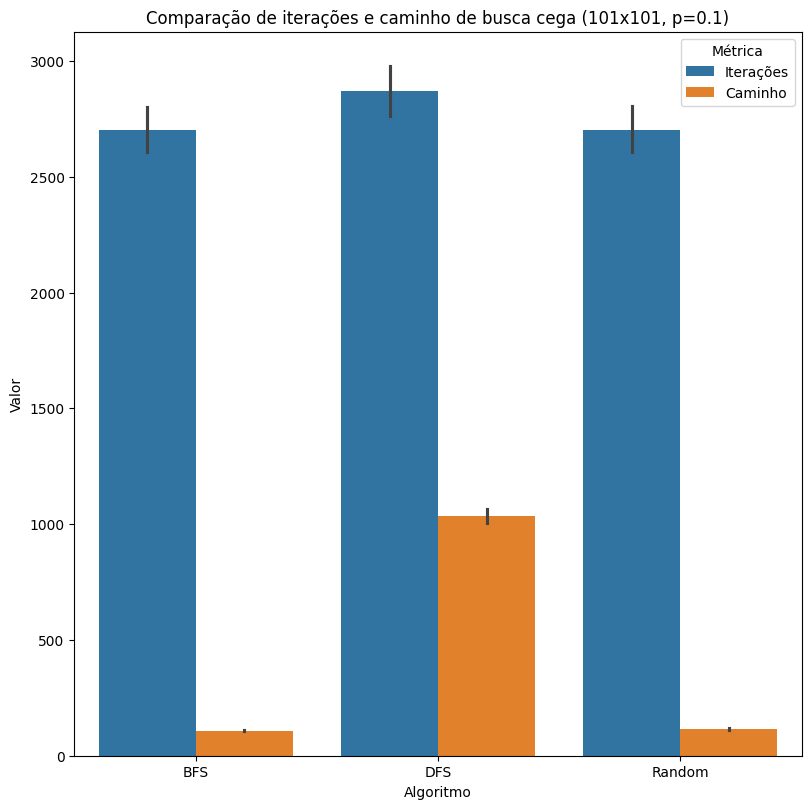

In [5]:
target_param = (101, 0.1)

data = []
for alg, values in results[target_param].items():
    if alg not in blind_names:
        continue
    for steps, path in values:
        data.append({'Algoritmo': pretty_names[alg], 'Métrica': 'Iterações', 'Valor': steps})
        data.append({'Algoritmo': pretty_names[alg], 'Métrica': 'Caminho', 'Valor': path})

df = pd.DataFrame(data=data)

plt.figure(figsize=(8, 8))
plt.title("Comparação de iterações e caminho de busca cega (101x101, p=0.1)")
plt.tight_layout()
sns.barplot(x='Algoritmo', y='Valor', hue='Métrica', data=df)

<Axes: title={'center': 'Comparação de iterações e caminho de busca cega (101x101, p=0.2)'}, xlabel='Algoritmo', ylabel='Valor'>

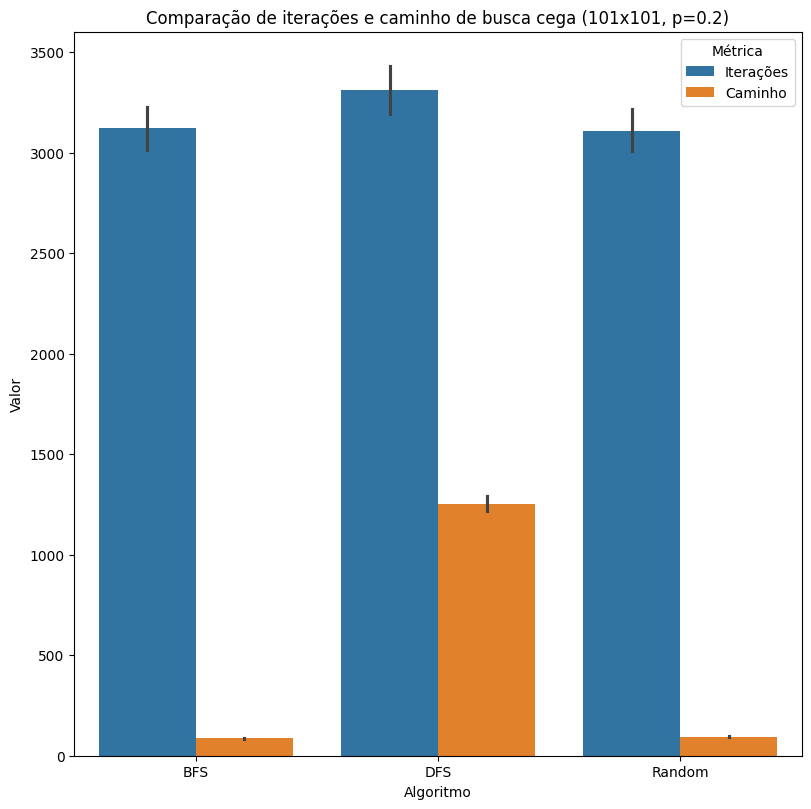

In [6]:
target_param = (101, 0.2)

data = []
for alg, values in results[target_param].items():
    if alg not in blind_names:
        continue
    for steps, path in values:
        data.append({'Algoritmo': pretty_names[alg], 'Métrica': 'Iterações', 'Valor': steps})
        data.append({'Algoritmo': pretty_names[alg], 'Métrica': 'Caminho', 'Valor': path})

df = pd.DataFrame(data=data)

plt.figure(figsize=(8, 8))
plt.title("Comparação de iterações e caminho de busca cega (101x101, p=0.2)")
plt.tight_layout()
sns.barplot(x='Algoritmo', y='Valor', hue='Métrica', data=df)

<Axes: title={'center': 'Comparação de iterações e caminho de busca informada (101x101, p=0.1)'}, xlabel='Algoritmo', ylabel='Valor'>

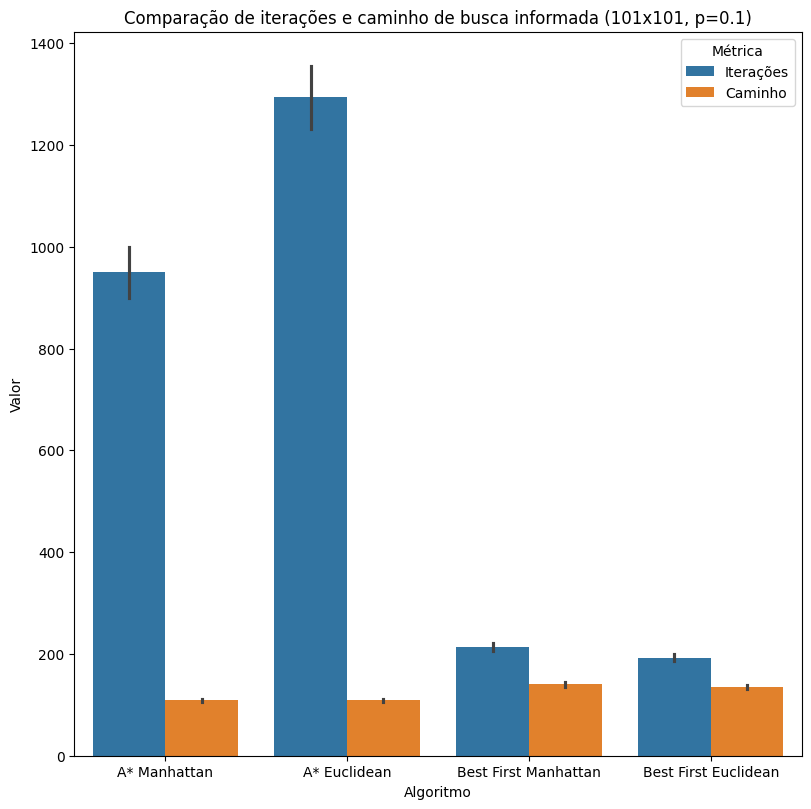

In [7]:
target_param = (101, 0.1)

data = []
for alg, values in results[target_param].items():
    if alg in blind_names:
        continue
    for steps, path in values:
        data.append({'Algoritmo': pretty_names[alg], 'Métrica': 'Iterações', 'Valor': steps})
        data.append({'Algoritmo': pretty_names[alg], 'Métrica': 'Caminho', 'Valor': path})

df = pd.DataFrame(data=data)

plt.figure(figsize=(8, 8))
plt.title("Comparação de iterações e caminho de busca informada (101x101, p=0.1)")
plt.tight_layout()
sns.barplot(x='Algoritmo', y='Valor', hue='Métrica', data=df)

<Axes: title={'center': 'Comparação de iterações e caminho de busca informada (101x101, p=0.2)'}, xlabel='Algoritmo', ylabel='Valor'>

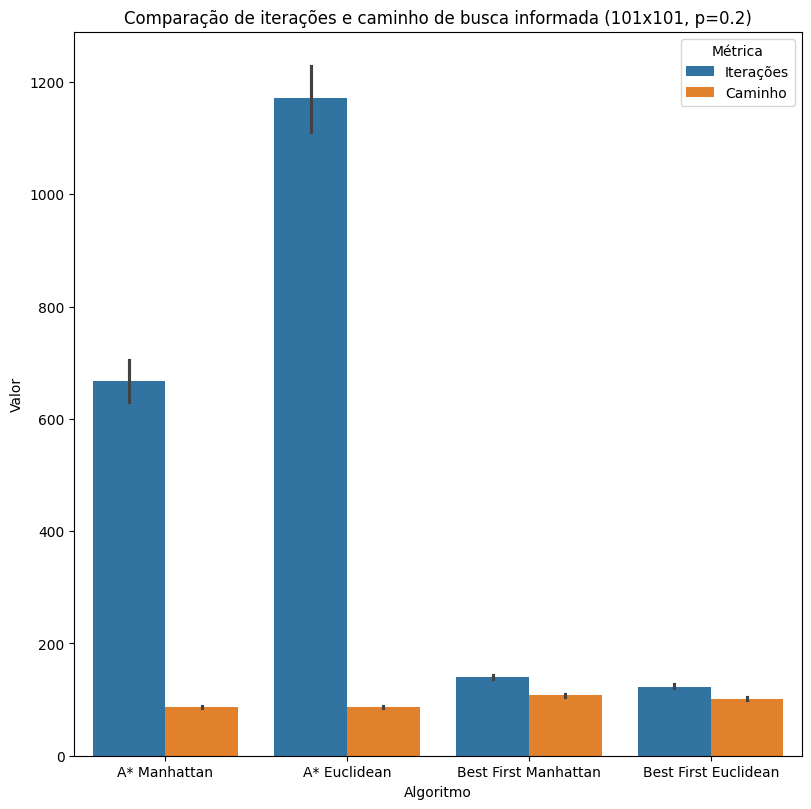

In [8]:
target_param = (101, 0.2)

data = []
for alg, values in results[target_param].items():
    if alg in blind_names:
        continue
    for steps, path in values:
        data.append({'Algoritmo': pretty_names[alg], 'Métrica': 'Iterações', 'Valor': steps})
        data.append({'Algoritmo': pretty_names[alg], 'Métrica': 'Caminho', 'Valor': path})

df = pd.DataFrame(data=data)

plt.figure(figsize=(8, 8))
plt.title("Comparação de iterações e caminho de busca informada (101x101, p=0.2)")
plt.tight_layout()
sns.barplot(x='Algoritmo', y='Valor', hue='Métrica', data=df)

In [9]:

best_algorithms = ('astar_man', 'bfirst_euc', 'bfs')

<Axes: title={'center': 'Melhores algoritmos (151x151, p=0.0)'}, xlabel='Algoritmo', ylabel='Valor'>

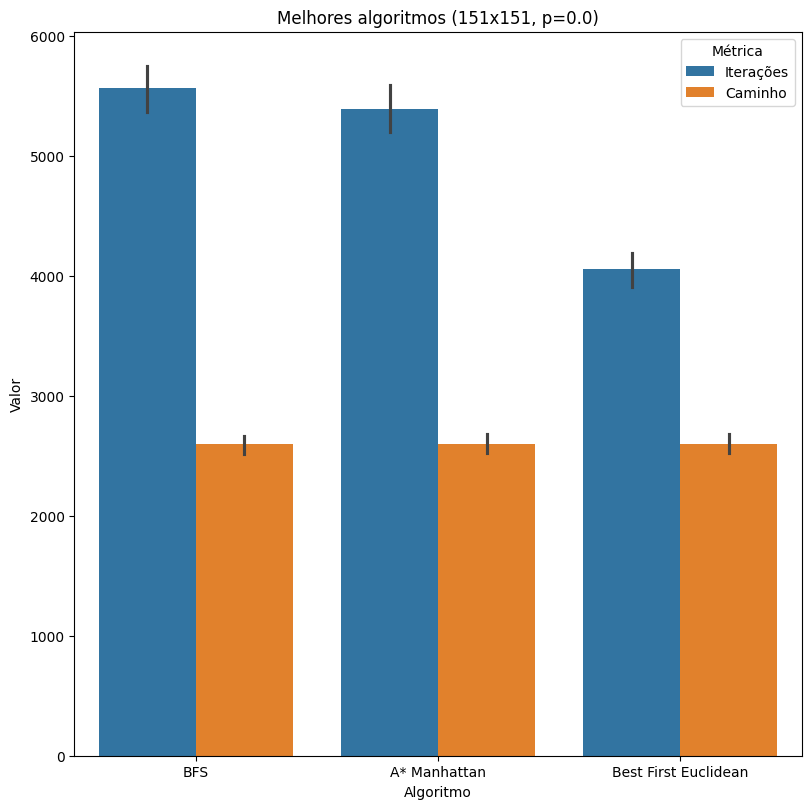

In [10]:
target_param = (151, 0.0)

data = []
for alg, values in results[target_param].items():
    if alg not in best_algorithms:
        continue
    for steps, path in values:
        data.append({'Algoritmo': pretty_names[alg], 'Métrica': 'Iterações', 'Valor': steps})
        data.append({'Algoritmo': pretty_names[alg], 'Métrica': 'Caminho', 'Valor': path})

df = pd.DataFrame(data=data)

plt.figure(figsize=(8, 8))
plt.title("Melhores algoritmos (151x151, p=0.0)")
plt.tight_layout()
sns.barplot(x='Algoritmo', y='Valor', hue='Métrica', data=df)

<Axes: title={'center': 'Melhores algoritmos (151x151, p=0.1)'}, xlabel='Algoritmo', ylabel='Valor'>

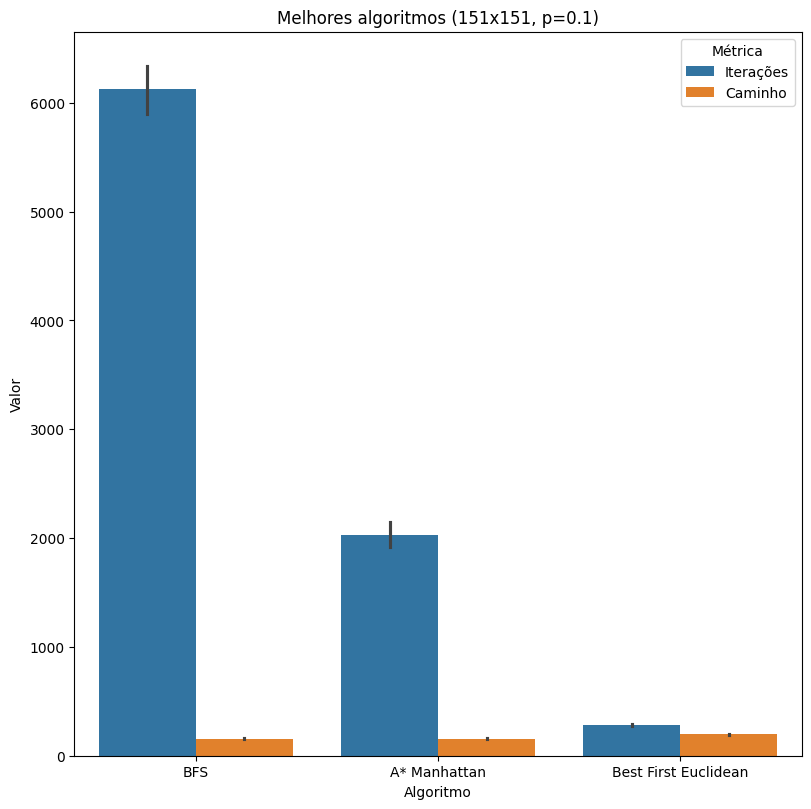

In [11]:
target_param = (151, 0.1)

data = []
for alg, values in results[target_param].items():
    if alg not in best_algorithms:
        continue
    for steps, path in values:
        data.append({'Algoritmo': pretty_names[alg], 'Métrica': 'Iterações', 'Valor': steps})
        data.append({'Algoritmo': pretty_names[alg], 'Métrica': 'Caminho', 'Valor': path})

df = pd.DataFrame(data=data)

plt.figure(figsize=(8, 8))
plt.title("Melhores algoritmos (151x151, p=0.1)")
plt.tight_layout()
sns.barplot(x='Algoritmo', y='Valor', hue='Métrica', data=df)

<Axes: title={'center': 'Melhores algoritmos (151x151, p=0.2)'}, xlabel='Algoritmo', ylabel='Valor'>

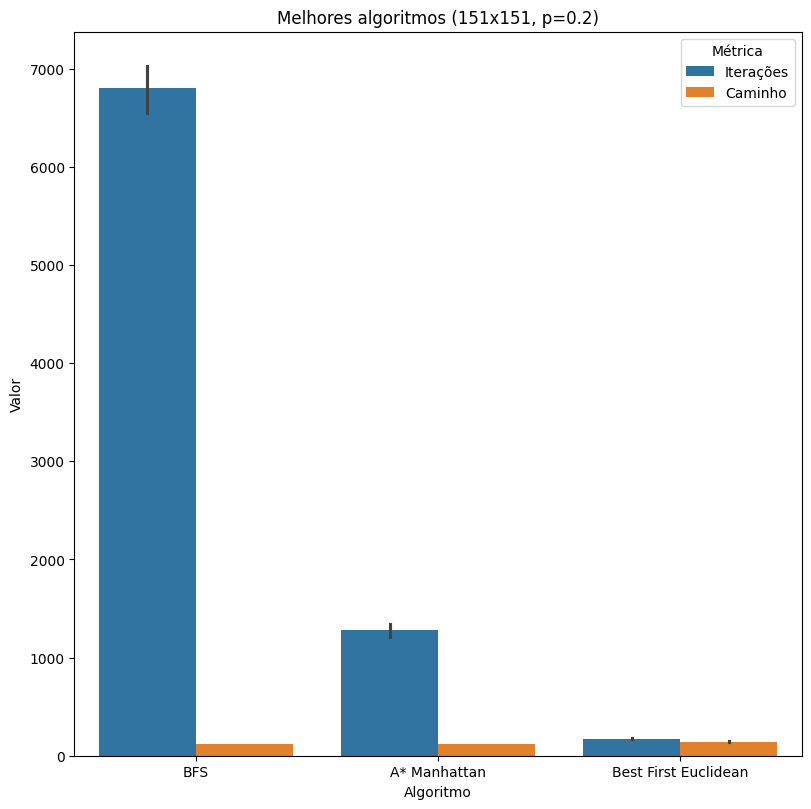

In [12]:

target_param = (151, 0.2)

data = []
for alg, values in results[target_param].items():
    if alg not in best_algorithms:
        continue
    for steps, path in values:
        data.append({'Algoritmo': pretty_names[alg], 'Métrica': 'Iterações', 'Valor': steps})
        data.append({'Algoritmo': pretty_names[alg], 'Métrica': 'Caminho', 'Valor': path})

df = pd.DataFrame(data=data)

plt.figure(figsize=(8, 8))
plt.title("Melhores algoritmos (151x151, p=0.2)")
plt.tight_layout()
sns.barplot(x='Algoritmo', y='Valor', hue='Métrica', data=df)